# Evaluate performace of `kissim` vs. profiling datasets

Summarize ligand-kinase pair performances based on multiple profiling datasets:

- Profiling datasets: Karaman and Davis
- `kissim` datasets: Different feature weighting schemes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging
import math
import itertools

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from src import data
from src.evaluation.ligand_vs_kinase_evaluator import LigandVsKinaseEvaluator

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results_archive/20210810-1/dfg_in"

## Define parameters

In [5]:
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

In [6]:
suffixes = ["15", "100", "010", "001", "110", "011", "101", "111"]
ligand_profiling_methods = ["karaman-davis"]

## Generate ROC/AUC data

### Ligand profiling method: karaman-davis

#### Kinase-kinase dataset: 15

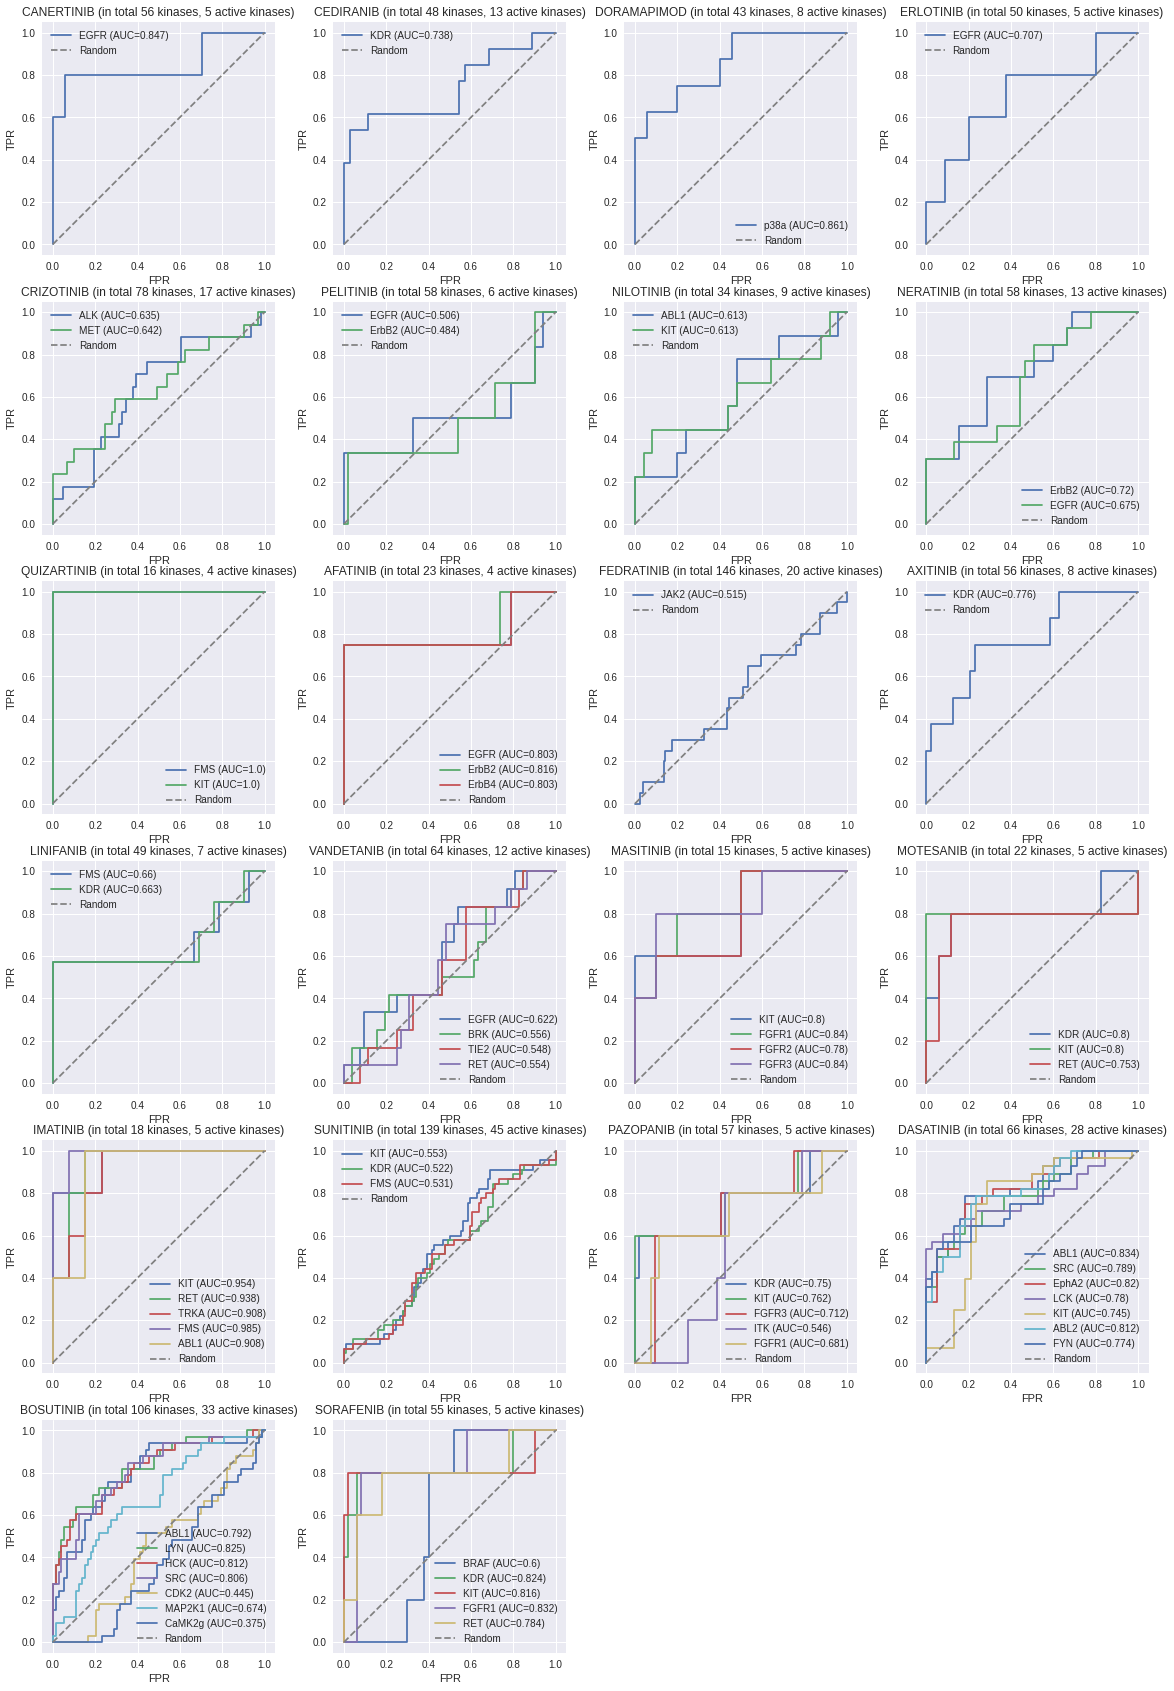

#### Kinase-kinase dataset: 100

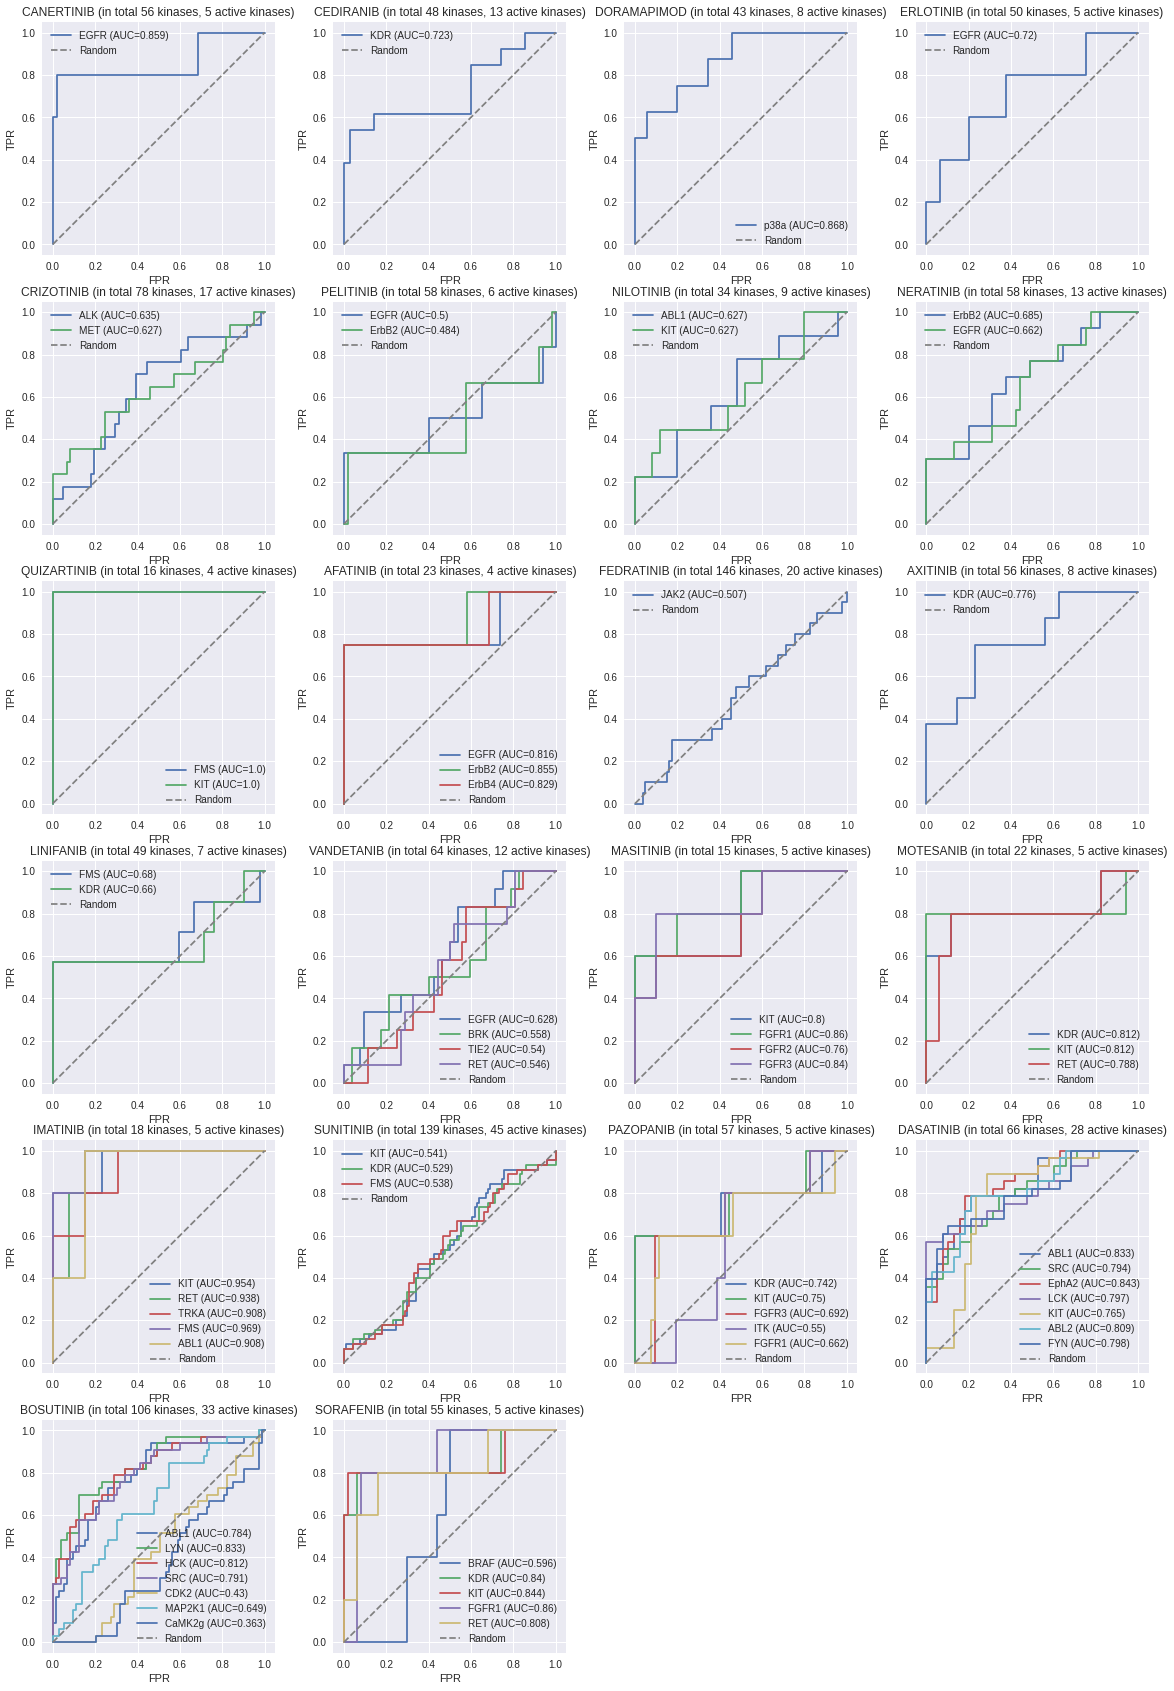

#### Kinase-kinase dataset: 010

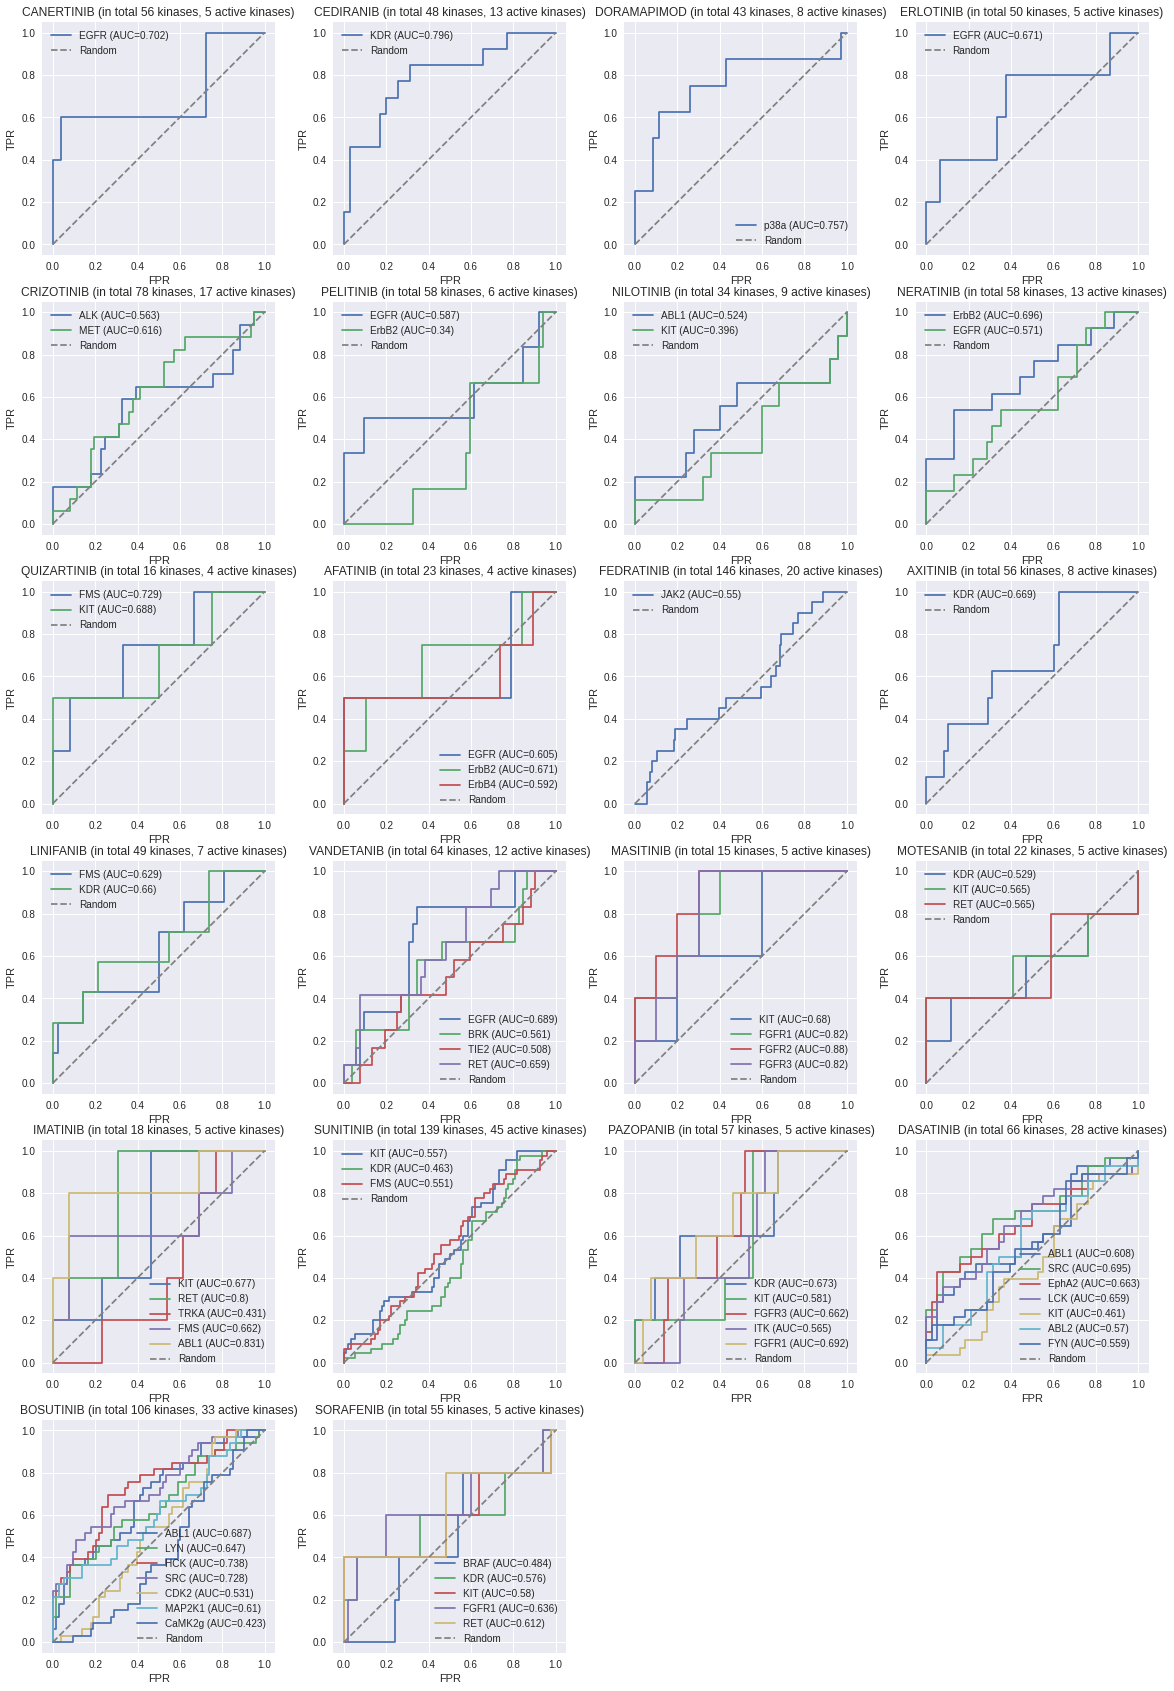

#### Kinase-kinase dataset: 001

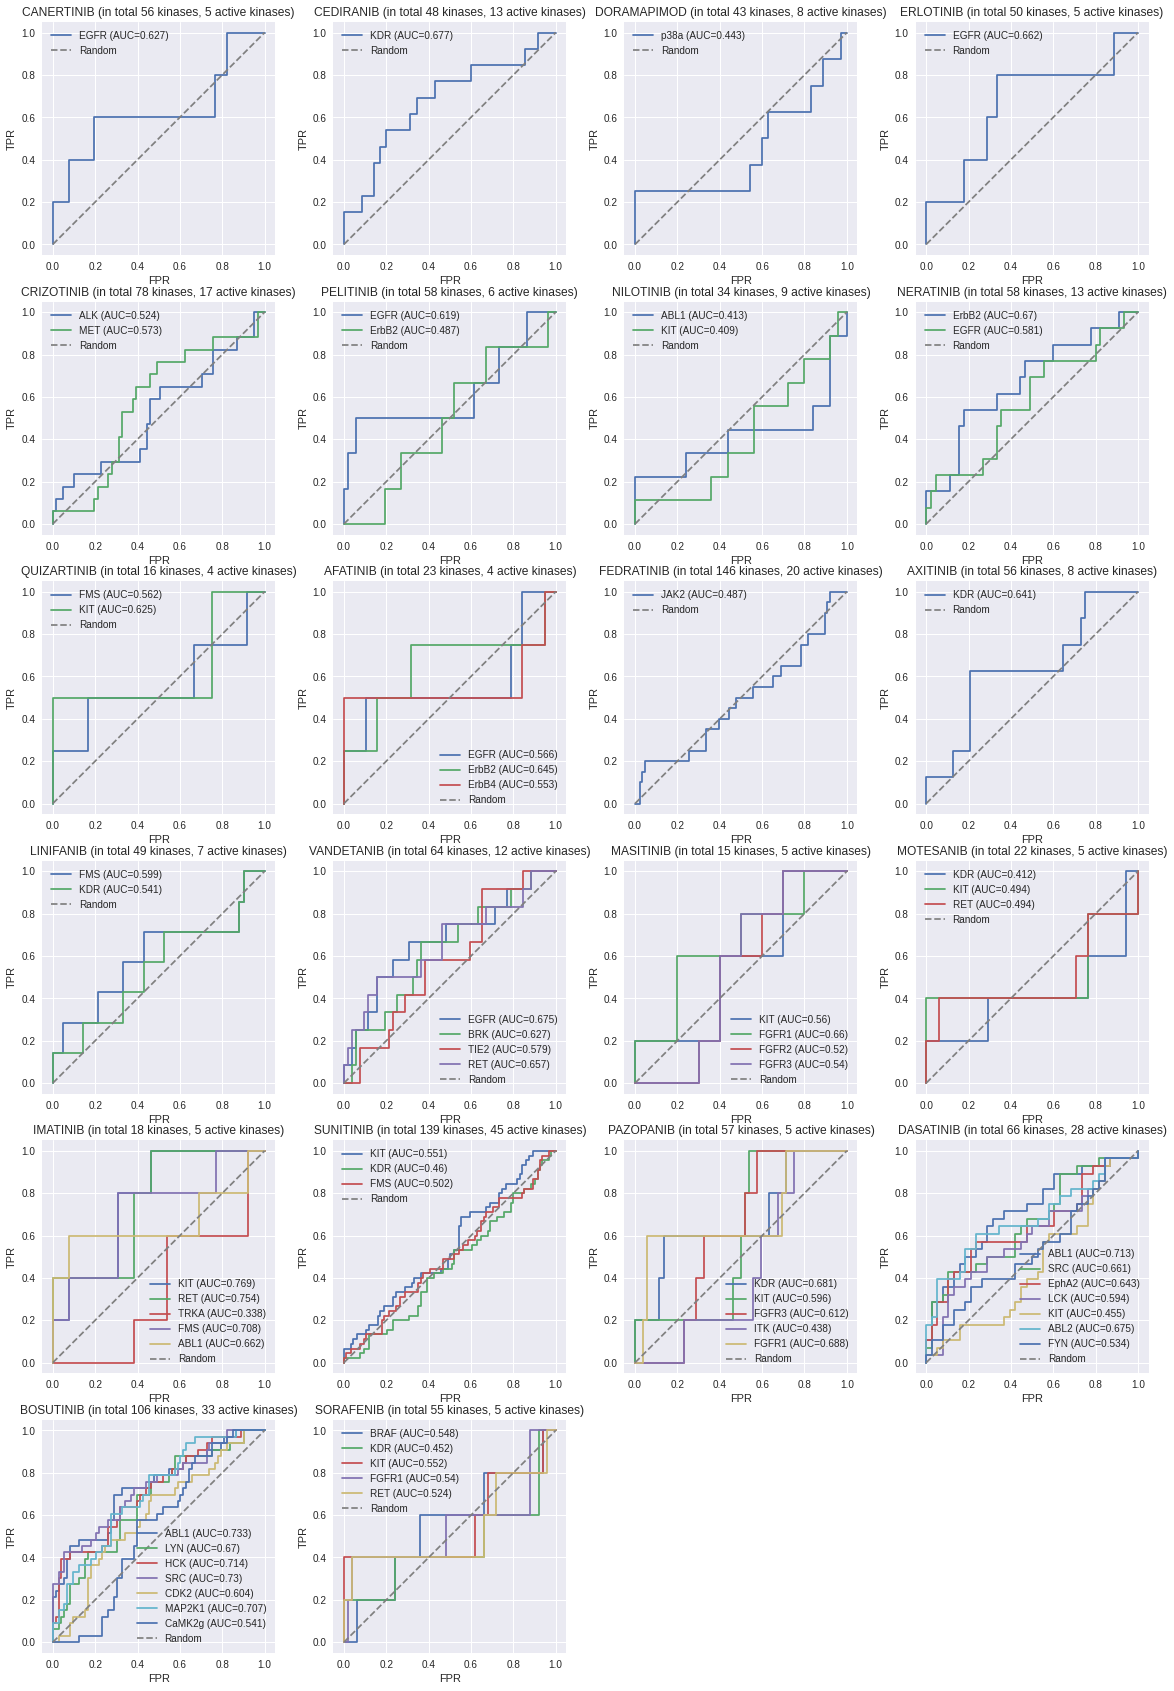

#### Kinase-kinase dataset: 110

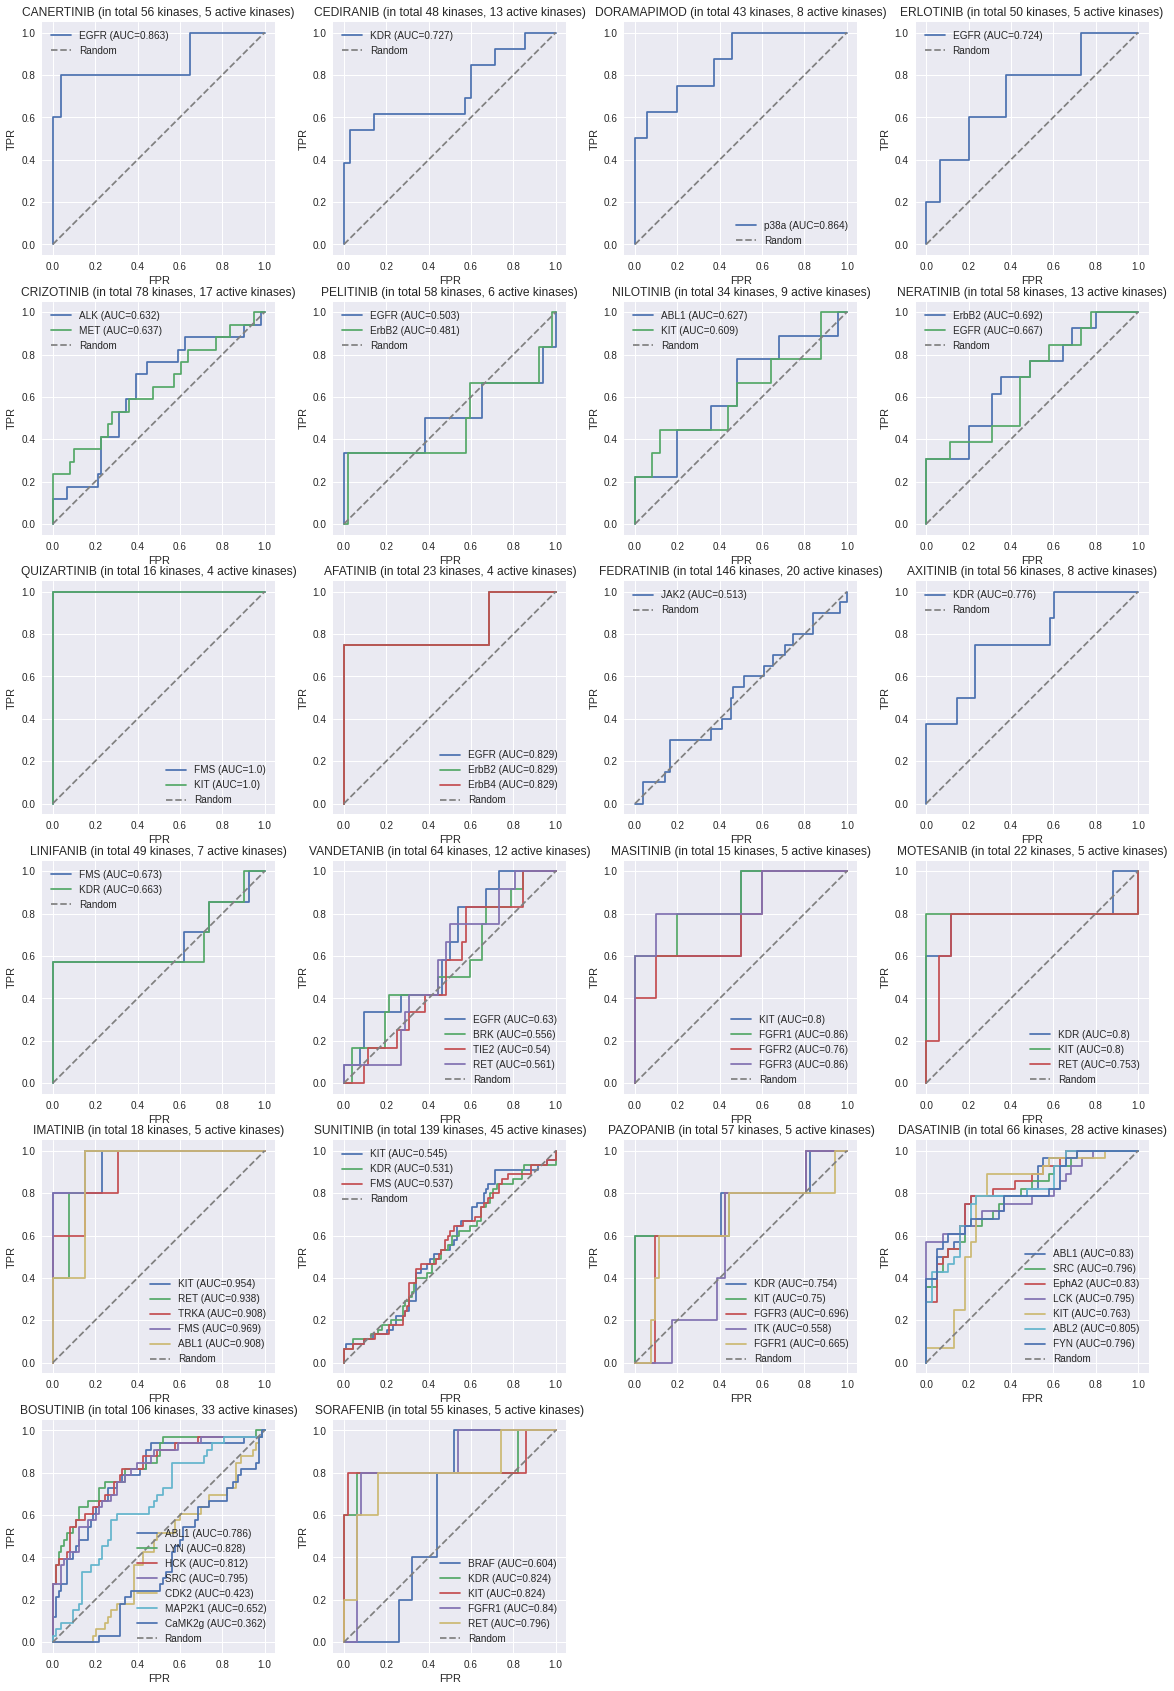

#### Kinase-kinase dataset: 011

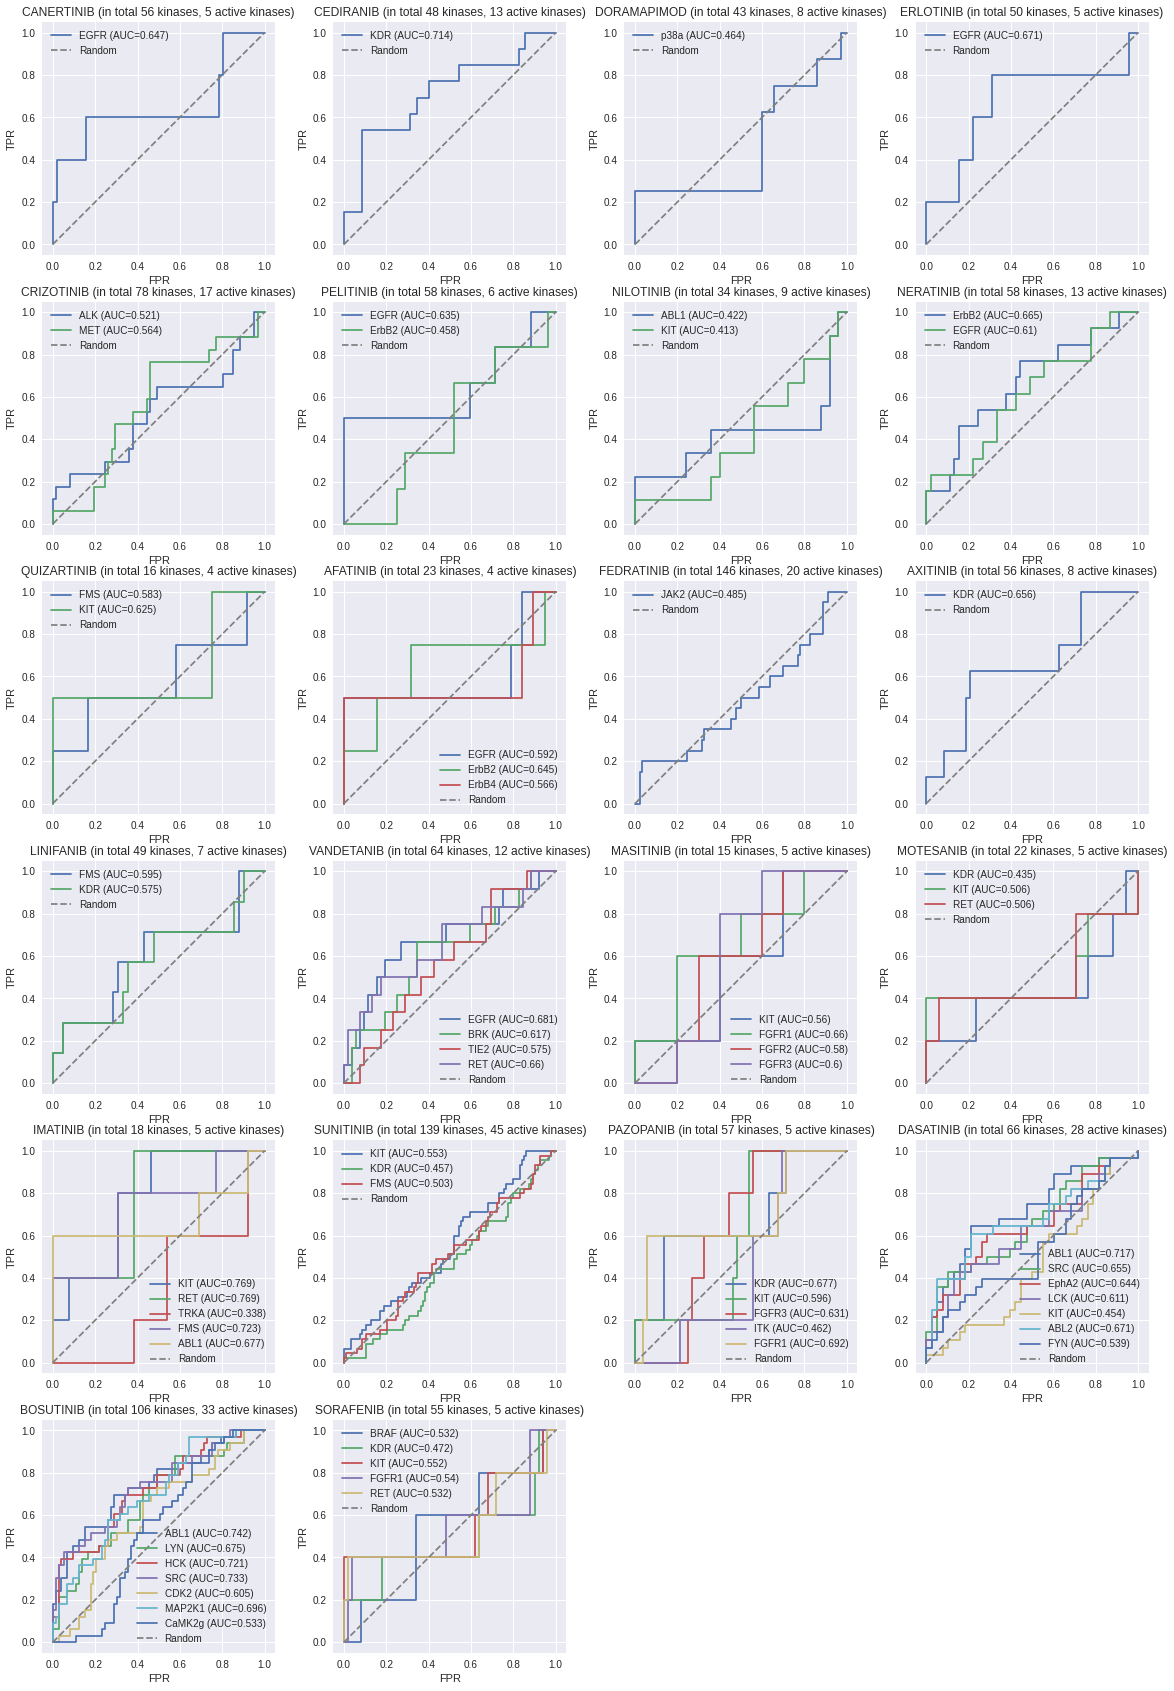

#### Kinase-kinase dataset: 101

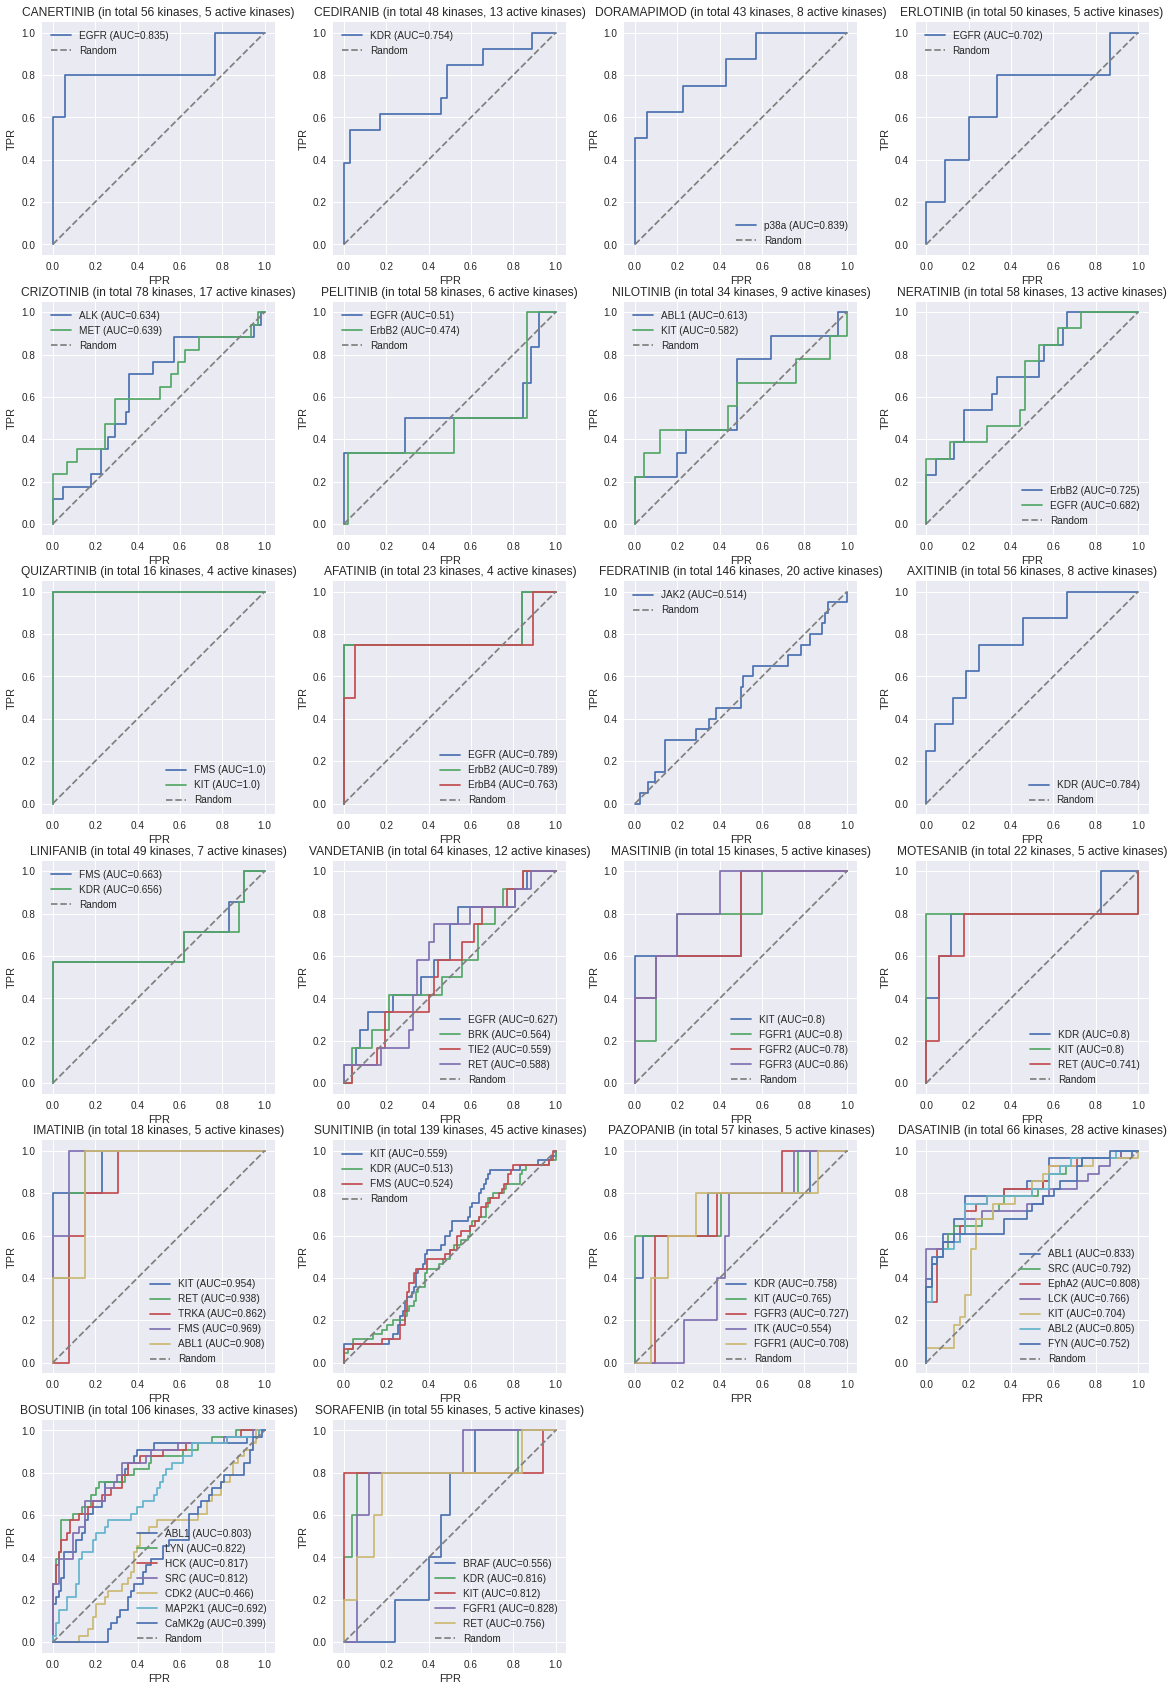

#### Kinase-kinase dataset: 111

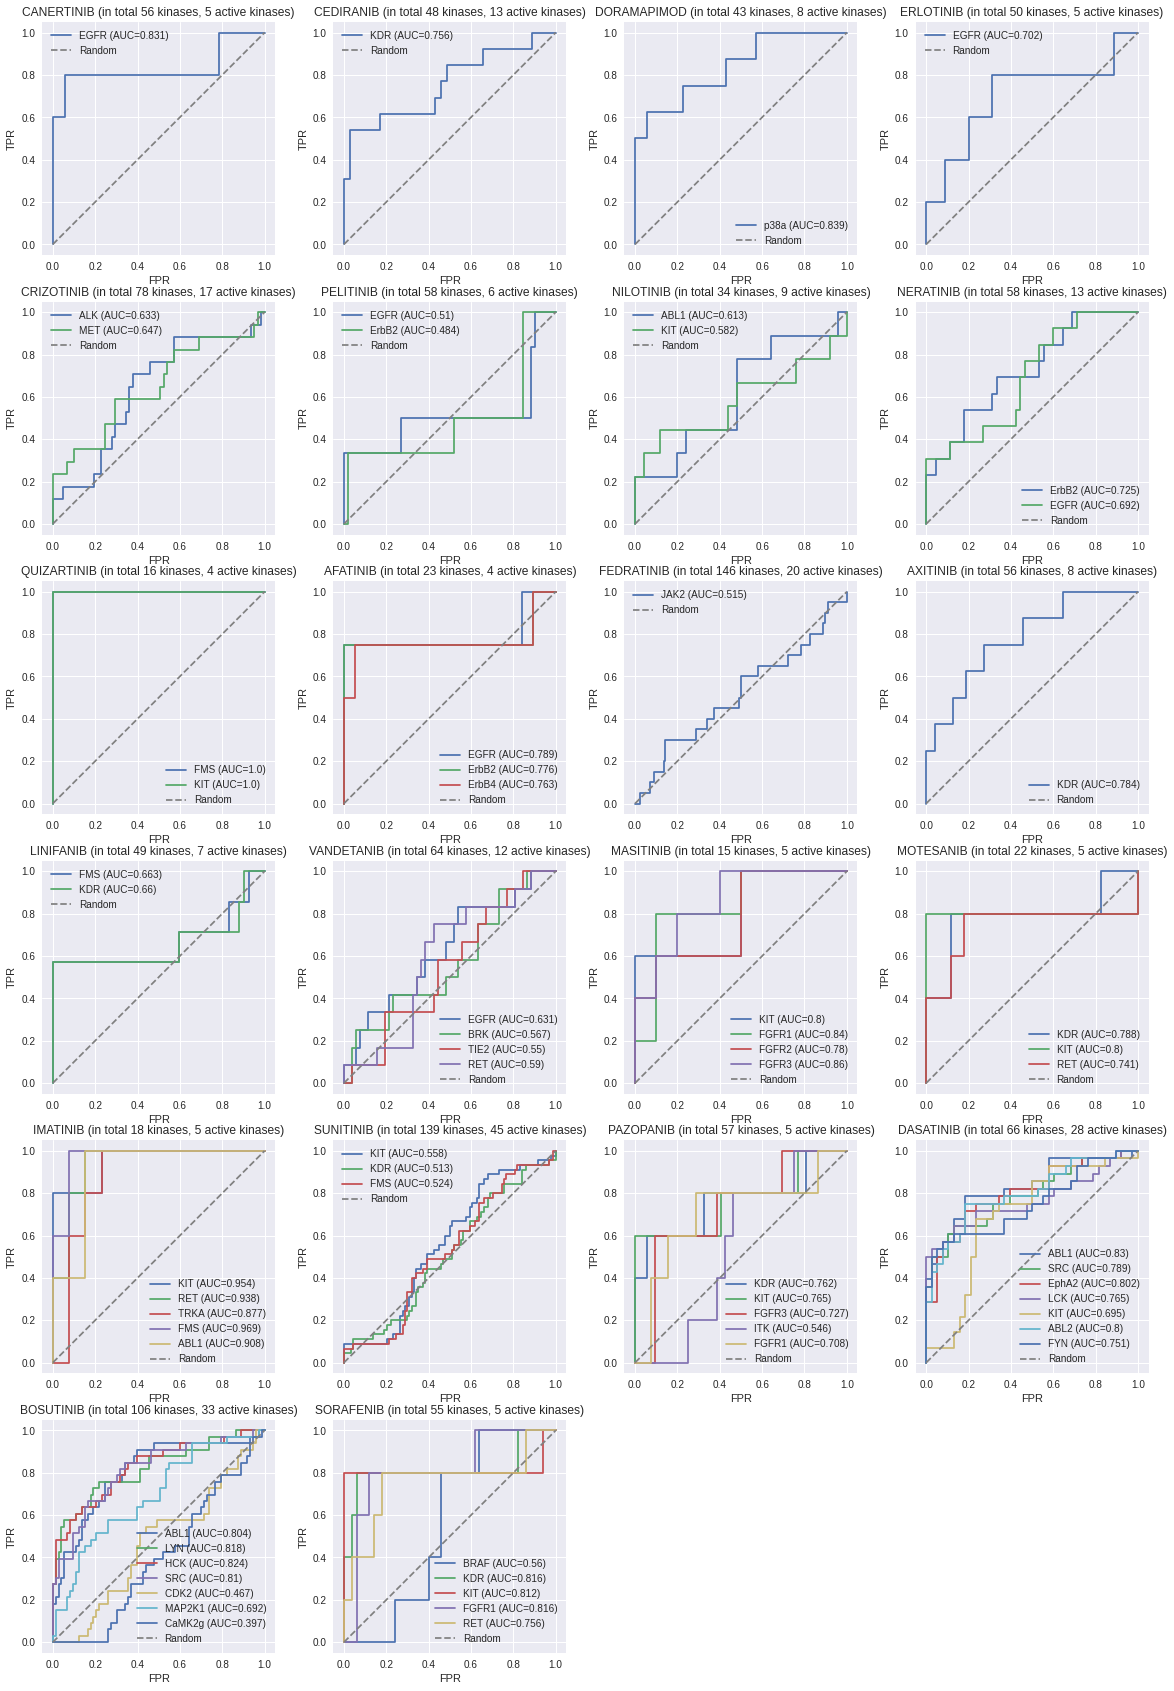

In [7]:
auc_dict = {}

for ligand_profiling_method in ligand_profiling_methods:
    display(Markdown(f"### Ligand profiling method: {ligand_profiling_method}"))
    auc_dict[ligand_profiling_method] = {}

    for suffix in suffixes:

        # Set path to file
        display(Markdown(f"#### Kinase-kinase dataset: {suffix}"))
        if suffix == "15":
            KINASE_KINASE_PATH = RESULTS / "fingerprint_distances.csv"
        else:
            KINASE_KINASE_PATH = RESULTS / f"fingerprint_distances_{suffix}.csv"

        # Kinase-kinase distances dataset
        kissim_df = data.distances.kissim(
            structure_kinase_mapping_by="minimum",
            kinmap_kinases=True,
            distances_path=KINASE_KINASE_PATH,
        )
        # Kinase-ligand profiling dataset
        profiling_df = data.profiling.load(
            ligand_profiling_method, pkidb_ligands=True, fda_approved=True
        )

        ligand_names = profiling_df.columns
        ligand_targets = data.targets.pkidb(ligand_names, fda_approved=False)
        ligand_kinase_pairs = (
            ligand_targets[["ligand.input", "targets.kinmap"]]
            .explode("targets.kinmap")
            .to_numpy()
            .tolist()
        )
        evaluator = LigandVsKinaseEvaluator(
            ligand_kinase_pairs,
            ligand_profiling_method,
            KINASE_DISTANCES_METHOD,
            KINASE_ACTIVITY_CUTOFF,
            KINASE_ACTIVITY_MAX,
            MIN_N_SHARED_KINASES,
            MIN_N_SHARED_ACTIVE_KINASES,
            kinase_kinase_path=KINASE_KINASE_PATH,
        )
        auc_list = evaluator.plot_roc_curves()
        # output_file = f"roc_{ligand_profiling_method}_{suffix}.png"
        # auc_list = evaluator.plot_roc_curves(output_file=output_file)
        plt.show()
        auc_dict[ligand_profiling_method][suffix] = auc_list

## Plot AUC distribution

### Ligand profiling method: karaman-davis

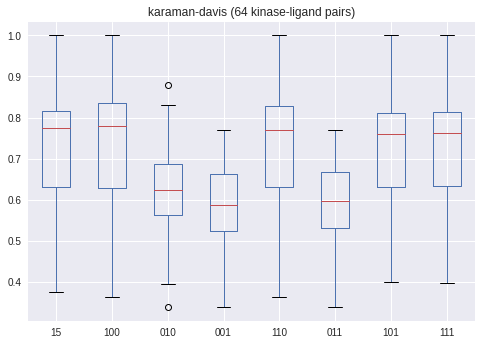

In [8]:
for profiling_name, auc in auc_dict.items():
    display(Markdown(f"### Ligand profiling method: {profiling_name}"))
    auc_df = pd.DataFrame(auc)
    auc_df.plot(kind="box", title=f"{profiling_name} ({auc_df.shape[0]} kinase-ligand pairs)")
    # plt.savefig(f"auc_{profiling_name}.png", bbox_inches="tight", dpi=300)
    plt.show()

In [9]:
auc_df.describe()

,15,100,010,001,110,011,101,111
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.732158,0.734574,0.623393,0.585402,0.733351,0.593090,0.728847,0.729180
std,0.140730,0.145065,0.107769,0.096603,0.143323,0.096274,0.136722,0.136699
min,0.375259,0.363221,0.339744,0.338462,0.362391,0.338462,0.399336,0.396845
25%,0.632064,0.627856,0.562597,0.523906,0.631174,0.532000,0.631819,0.632298
50%,0.775239,0.779885,0.622726,0.587591,0.769600,0.598077,0.760425,0.762348
75%,0.817122,0.834533,0.687130,0.661709,0.828947,0.666481,0.811966,0.813000
max,1.000000,1.000000,0.880000,0.769231,1.000000,0.769231,1.000000,1.000000


In [10]:
auc_df.to_csv(RESULTS / "auc.csv", index=None)

## Scatter AUC values between weighting schemes

Use only best performing feature weights:

In [11]:
best_feature_weights = ["15", "100", "110", "101", "111"]

### Ligand profiling method: karaman-davis

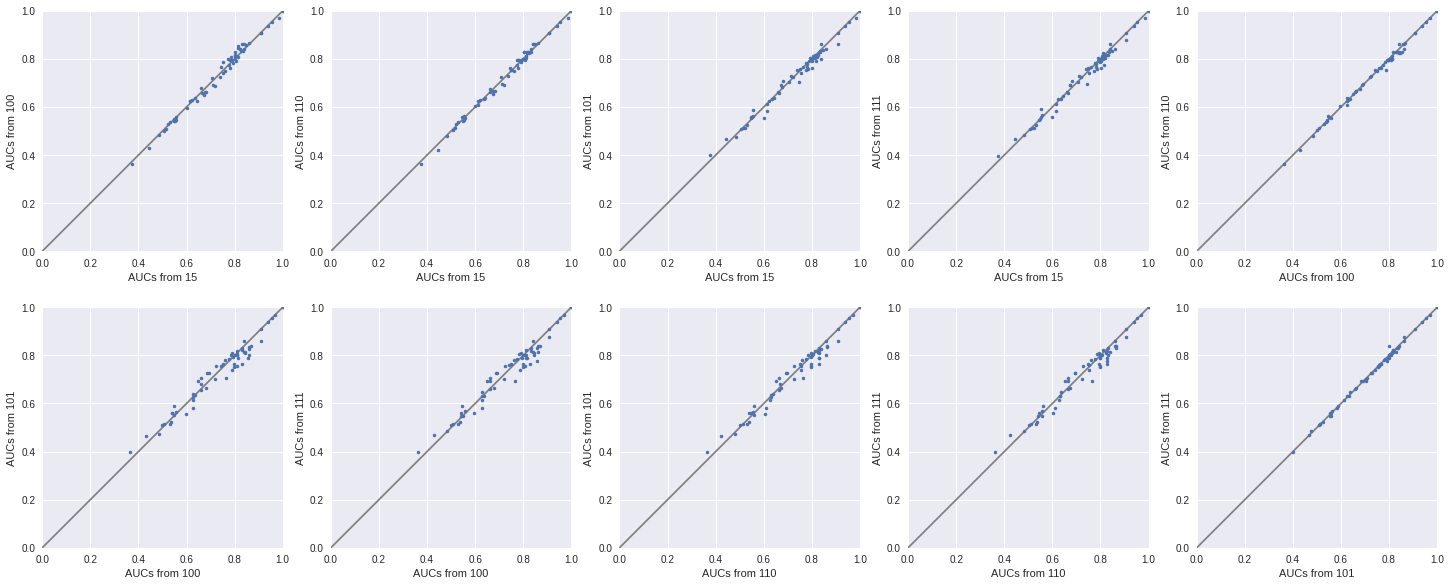

In [12]:
for profiling_name, auc in auc_dict.items():

    display(Markdown(f"### Ligand profiling method: {profiling_name}"))
    pairs = list(itertools.combinations(best_feature_weights, 2))
    n_cols = 5
    n_rows = math.ceil(len(pairs) / n_cols)
    _, axes = plt.subplots(figsize=(n_cols * 5, n_rows * 5), nrows=n_rows, ncols=n_cols)
    axes = axes.reshape(-1)

    for i, pair in enumerate(pairs):

        axes[i].plot([0, 1], [0, 1], "grey")
        axes[i].plot(auc_df[pair[0]], auc_df[pair[1]], ".")
        axes[i].set_box_aspect(1)
        axes[i].set_xlim([0, 1])
        axes[i].set_ylim([0, 1])
        axes[i].set_xlabel(f"AUCs from {pair[0]}")
        axes[i].set_ylabel(f"AUCs from {pair[1]}")

    plt.show()